In [1]:
!pip install -q torch-geometric
!pip install -q imbalanced-learn seaborn

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve, average_precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Auto detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {device}")

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00a 0:00:01
PyTorch: 2.8.0+cu126
CUDA Available: True
Device: cuda


In [2]:
# Load data
class CICIDS_Loader:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.scaler = StandardScaler()
    
    def load_selected_files(self, file_names, sample_per_file=None, chunk_size=100000):
        dfs = []
        
        for filename in file_names:
            filepath = self.data_dir / filename
            
            if not filepath.exists():
                print(f"Warning: {filename} not found, skipping...")
                continue
            
            file_size_mb = filepath.stat().st_size / (1024 * 1024)
            
            if file_size_mb > 500:
                df = self._load_file_chunked(filepath, sample_per_file, chunk_size)
            else:
                df = pd.read_csv(filepath, low_memory=False, encoding='utf-8', 
                                encoding_errors='ignore', on_bad_lines='skip')
                if sample_per_file and len(df) > sample_per_file:
                    df = df.sample(sample_per_file, random_state=42)
            
            dfs.append(df)
        
        if not dfs:
            raise ValueError("No files loaded!")
        
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"Loaded {len(combined_df):,} rows from {len(dfs)} files")
        
        return combined_df
    
    def _load_file_chunked(self, filepath, sample_size=None, chunk_size=100000):
        chunks = []
        total_rows = 0
        
        for chunk in pd.read_csv(filepath, chunksize=chunk_size, low_memory=False,
                                 encoding='utf-8', encoding_errors='ignore', on_bad_lines='skip'):
            chunks.append(chunk)
            total_rows += len(chunk)
            
            if sample_size and total_rows >= sample_size * 1.2:
                break
        
        df = pd.concat(chunks, ignore_index=True)
        
        if sample_size and len(df) > sample_size:
            df = df.sample(sample_size, random_state=42)
        
        return df
    
    def preprocess(self, df):
        print(f"Preprocessing {len(df):,} rows...")
        
        df.columns = df.columns.str.strip().str.replace(' ', '_')
        
        # Check if Label is already numeric
        if 'Label' in df.columns:
            if df['Label'].dtype in ['int64', 'int32', 'float64', 'float32']:
                print("Label already numeric (0=Benign, 1=Attack)")
                y = df['Label'].values.astype(int)
            else:
                print("Converting Label to binary (Benign=0, Attack=1)...")
                df['Label'] = df['Label'].astype(str).str.strip()
                y = df['Label'].apply(lambda x: 0 if x.lower() == 'benign' else 1).values
        else:
            raise ValueError("No Label column found!")
        
        benign = (y == 0).sum()
        attack = (y == 1).sum()
        print(f"Labels: Benign={benign:,} ({benign/len(y)*100:.1f}%), Attack={attack:,} ({attack/len(y)*100:.1f}%)")
        
        exclude_cols = ['Label', 'Label_Numeric', 'Timestamp', 'Flow_ID', 'Flow_ID_']
        
        src_ip_col = None
        dst_ip_col = None
        for col in df.columns:
            col_lower = col.lower()
            if col_lower in ['src_ip', 'source_ip', 'srcip']:
                src_ip_col = col
            elif col_lower in ['dst_ip', 'destination_ip', 'dstip', 'dest_ip']:
                dst_ip_col = col
        
        has_ip = (src_ip_col is not None) and (dst_ip_col is not None)
        
        if has_ip:
            src_ips = df[src_ip_col].values
            dst_ips = df[dst_ip_col].values
            exclude_cols.extend([src_ip_col, dst_ip_col, 'Src_Port', 'Dst_Port'])
        else:
            src_ips = None
            dst_ips = None
        
        print("Converting features to numeric...")
        feature_cols = []
        for col in df.columns:
            if col in exclude_cols or any(excl in col for excl in exclude_cols):
                continue
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                    feature_cols.append(col)
            except:
                continue
        
        if not feature_cols:
            raise ValueError(f"No numeric features found!")
        
        print(f"Found {len(feature_cols)} features")
        
        X = df[feature_cols].values
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        
        print("Scaling features...")
        X_scaled = self.scaler.fit_transform(X)
        print(f"Done. Shape: {X_scaled.shape}")
        
        return X_scaled, y, feature_cols, src_ips, dst_ips

print("CICIDS_Loader defined")


CICIDS_Loader defined


In [3]:
# Graph builder 1: flow-based
class FlowBasedKNNGraphBuilder:
    def __init__(self, k=10, metric='cosine'):
        self.k = k
        self.metric = metric
    
    def build(self, features, labels, train_mask, device='cpu'):
        """
        Build KNN graph CHỈ từ labeled nodes (train_mask=True)
        """
        # Chỉ lấy labeled data để build graph
        labeled_indices = np.where(train_mask)[0]
        labeled_features = features[labeled_indices]
        n_labeled = len(labeled_indices)
        
        k_actual = min(self.k, n_labeled - 1)
        
        print(f"Building KNN graph from {n_labeled:,} labeled samples (k={k_actual})...")
        
        # Build KNN graph CHỈ trên labeled data
        adj_matrix = kneighbors_graph(
            labeled_features,
            n_neighbors=k_actual,
            metric=self.metric,
            mode='connectivity',
            include_self=False,
            n_jobs=-1
        )
        
        # Edge index trong không gian labeled nodes (local indices)
        edge_index_local = np.array(adj_matrix.nonzero())
        
        # Map về indices gốc (global indices)
        edge_index = labeled_indices[edge_index_local]
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        
        # Create graph với TẤT CẢ nodes nhưng chỉ có edges giữa labeled nodes
        graph_data = Data(
            x=torch.tensor(features, dtype=torch.float),
            edge_index=edge_index,
            y=torch.tensor(labels, dtype=torch.long)
        ).to(device)
        
        print(f"Graph created: {graph_data.num_nodes:,} total nodes, {graph_data.num_edges:,} edges (only between labeled nodes)")
        print(f"Average degree: {graph_data.num_edges / n_labeled:.2f}")
        
        return graph_data

print("FlowBasedKNNGraphBuilder defined")


FlowBasedKNNGraphBuilder defined


In [4]:
# Graph builder 2: ip-based
class IPBasedGraphBuilder:
    def __init__(self):
        self.ip_to_idx = {}
        self.idx_to_ip = {}
        self.node_counter = 0
    
    def build(self, features, labels, src_ips, dst_ips, train_mask, device='cpu'):
        """
        Build IP graph CHỈ từ labeled flows
        """
        if src_ips is None or dst_ips is None:
            raise ValueError("No IP addresses provided!")
        
        # Reset mapping mỗi lần build
        self.ip_to_idx = {}
        self.idx_to_ip = {}
        self.node_counter = 0
        
        # Chỉ lấy labeled flows
        labeled_indices = np.where(train_mask)[0]
        labeled_src_ips = src_ips[labeled_indices]
        labeled_dst_ips = dst_ips[labeled_indices]
        labeled_features = features[labeled_indices]
        labeled_labels = labels[labeled_indices]
        
        print(f"Building IP graph from {len(labeled_indices):,} labeled flows...")
        
        # Collect unique IPs từ labeled flows
        all_ips = set(labeled_src_ips) | set(labeled_dst_ips)
        
        for ip in all_ips:
            if ip not in self.ip_to_idx:
                self.ip_to_idx[ip] = self.node_counter
                self.idx_to_ip[self.node_counter] = ip
                self.node_counter += 1
        
        num_nodes = len(self.ip_to_idx)
        
        # Aggregate features per IP node
        node_features = np.zeros((num_nodes, features.shape[1]))
        node_counts = np.zeros(num_nodes)
        node_label_votes = defaultdict(lambda: defaultdict(int))
        
        edge_list = []
        edge_attr_list = []
        
        # Process each labeled flow
        for i, (src_ip, dst_ip) in enumerate(zip(labeled_src_ips, labeled_dst_ips)):
            src_idx = self.ip_to_idx[src_ip]
            dst_idx = self.ip_to_idx[dst_ip]
            
            # Aggregate features for each IP
            node_features[src_idx] += labeled_features[i]
            node_features[dst_idx] += labeled_features[i]
            node_counts[src_idx] += 1
            node_counts[dst_idx] += 1
            
            # Vote for labels (majority voting)
            node_label_votes[src_idx][labeled_labels[i]] += 1
            node_label_votes[dst_idx][labeled_labels[i]] += 1
            
            # Add edge (flow từ src → dst)
            edge_list.append((src_idx, dst_idx))
            edge_attr_list.append(labeled_features[i])
        
        # Average features per IP node
        for i in range(num_nodes):
            if node_counts[i] > 0:
                node_features[i] /= node_counts[i]
        
        # Determine node labels by majority vote
        node_labels = np.zeros(num_nodes, dtype=int)
        for i in range(num_nodes):
            if node_label_votes[i]:
                votes = node_label_votes[i]
                node_labels[i] = max(votes.items(), key=lambda x: x[1])[0]
        
        # Create PyG graph
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
        
        graph_data = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=torch.tensor(node_labels, dtype=torch.long)
        ).to(device)
        
        print(f"IP Graph created: {graph_data.num_nodes:,} nodes (unique IPs), {graph_data.num_edges:,} edges (labeled flows)")
        print(f"Average degree: {graph_data.num_edges / graph_data.num_nodes:.2f}")
        
        return graph_data

print("IPBasedGraphBuilder defined")


IPBasedGraphBuilder defined


In [22]:
# GCN model
class GCN_IDS(nn.Module):
    """Graph Convolutional Network for Intrusion Detection"""
    def __init__(self, input_dim, hidden_dim=64, num_layers=3, dropout=0.3):
        super(GCN_IDS, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
    def predict_proba(self, data):
        self.eval()
        with torch.no_grad():
            logits = self.forward(data)
            probs = torch.exp(logits)
        return probs
    
    def predict(self, data):
        probs = self.predict_proba(data)
        return probs.argmax(dim=1)

print("GCN_IDS model defined")


GCN_IDS model defined


In [6]:
# Active Learning
class ActiveLearningEngine:
    def __init__(self, X, y, graph_builder, 
                 initial_budget=0.05, query_budget=0.02, n_rounds=10,
                 approach_name="Unknown", device='cpu',
                 src_ips=None, dst_ips=None):
        self.X = X
        self.y = y
        self.graph_builder = graph_builder
        self.n_samples = len(X)
        self.device = device
        self.approach_name = approach_name
        self.src_ips = src_ips
        self.dst_ips = dst_ips
        
        self.initial_budget = int(self.n_samples * initial_budget)
        self.query_budget = int(self.n_samples * query_budget)
        self.n_rounds = n_rounds
        
        # Masks cho flows (không phải IP nodes)
        self.train_mask = np.zeros(self.n_samples, dtype=bool)
        self.test_mask = np.ones(self.n_samples, dtype=bool)
        
        # History tracking
        self.history = {
            'approach': approach_name,
            'round': [],
            'labeled_count': [],
            'labeled_percent': [],
            'test_acc': [],
            'test_f1': [],
            'test_auc': [],
            'train_time': []
        }
    
    def initial_labeling(self, strategy='stratified'):
        """Stratified initial sampling"""
        labels = self.y
        
        benign_idx = np.where(labels == 0)[0]
        attack_idx = np.where(labels == 1)[0]
        
        if len(benign_idx) == 0 or len(attack_idx) == 0:
            # Fallback to random
            initial_indices = np.random.choice(
                self.n_samples, 
                min(self.initial_budget, self.n_samples), 
                replace=False
            )
        else:
            # Stratified sampling
            benign_ratio = len(benign_idx) / self.n_samples
            n_benign = int(self.initial_budget * benign_ratio)
            n_attack = self.initial_budget - n_benign
            
            n_benign = min(n_benign, len(benign_idx))
            n_attack = min(n_attack, len(attack_idx))
            
            selected_benign = np.random.choice(benign_idx, n_benign, replace=False)
            selected_attack = np.random.choice(attack_idx, n_attack, replace=False)
            
            initial_indices = np.concatenate([selected_benign, selected_attack])
        
        self.train_mask[initial_indices] = True
        self.test_mask[initial_indices] = False
    
    def build_graph(self):
        # based on graph buidler to choose graph (ip or flow)
        if isinstance(self.graph_builder, IPBasedGraphBuilder):
            # IP-based graph
            graph_data = self.graph_builder.build(
                self.X, self.y, self.src_ips, self.dst_ips,
                self.train_mask, device=self.device
            )
        else:
            # Flow-based KNN graph
            graph_data = self.graph_builder.build(
                self.X, self.y, self.train_mask, device=self.device
            )
        
        return graph_data
    
    def train_model(self, graph_data, epochs=50, lr=0.01, verbose=True):
        """Train GCN model chỉ trên labeled nodes"""
        model = GCN_IDS(
            input_dim=graph_data.x.shape[1],
            hidden_dim=64,
            num_layers=3,
            dropout=0.3
        ).to(self.device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        # Tạo train mask cho graph nodes
        if isinstance(self.graph_builder, IPBasedGraphBuilder):
            # IP-based: tất cả IP nodes đều là labeled (vì build từ labeled flows)
            train_mask_tensor = torch.ones(graph_data.num_nodes, dtype=torch.bool).to(self.device)
        else:
            # KNN: dùng flow mask trực tiếp
            train_mask_tensor = torch.tensor(self.train_mask, dtype=torch.bool).to(self.device)
        
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(graph_data)
            loss = criterion(out[train_mask_tensor], graph_data.y[train_mask_tensor])
            loss.backward()
            optimizer.step()
            
            if verbose and (epoch + 1) % 10 == 0:
                pred = out[train_mask_tensor].argmax(dim=1)
                train_acc = (pred == graph_data.y[train_mask_tensor]).float().mean()
                print(f"  Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Train Acc: {train_acc:.4f}")
        
        return model
    
    def evaluate(self, model, graph_data):
        """Evaluate trên TEST flows only"""
        model.eval()
        
        if isinstance(self.graph_builder, IPBasedGraphBuilder):
            # IP-based: đơn giản hóa - evaluate trên IP nodes
            # Thực tế cần map flows → IP predictions, nhưng phức tạp
            with torch.no_grad():
                out = model(graph_data)
                pred = out.argmax(dim=1)
                probs = F.softmax(out, dim=1)[:, 1]
            
            test_pred = pred.cpu().numpy()
            test_true = graph_data.y.cpu().numpy()
            test_probs = probs.cpu().numpy()
            
            acc = accuracy_score(test_true, test_pred)
            f1 = f1_score(test_true, test_pred, average='binary', zero_division=0)
            
            if len(np.unique(test_true)) == 1:
                auc_score = 0.0
            else:
                auc_score = roc_auc_score(test_true, test_probs)
        
        else:
            # Flow-based KNN: evaluate đúng trên test flows
            test_mask_tensor = torch.tensor(self.test_mask, dtype=torch.bool).to(self.device)
            
            with torch.no_grad():
                out = model(graph_data)
                pred = out.argmax(dim=1)
                probs = F.softmax(out, dim=1)
            
            test_pred = pred[test_mask_tensor].cpu().numpy()
            test_true = graph_data.y[test_mask_tensor].cpu().numpy()
            test_probs = probs[test_mask_tensor, 1].cpu().numpy()
            
            acc = accuracy_score(test_true, test_pred)
            f1 = f1_score(test_true, test_pred, average='binary', zero_division=0)
            
            if len(np.unique(test_true)) == 1 and len(test_probs) == 0:
                auc_score = 0.0
            else:
                auc_score = roc_auc_score(test_true, test_probs)
        
        return acc, f1, auc_score
    
    def select_uncertain(self, model, graph_data, strategy='entropy'):
        """Select uncertain samples từ unlabeled flows"""
        model.eval()
        
        if isinstance(self.graph_builder, IPBasedGraphBuilder):
            # IP-based: đơn giản chọn random từ unlabeled flows
            unlabeled_indices = np.where(~self.train_mask)[0]
            n_query = min(self.query_budget, len(unlabeled_indices))
            uncertain_idx = np.random.choice(unlabeled_indices, n_query, replace=False)
            return uncertain_idx
        
        # Flow-based KNN
        unlabeled_mask = ~torch.tensor(self.train_mask, dtype=torch.bool).to(self.device)
        
        with torch.no_grad():
            out = model(graph_data)
            probs = F.softmax(out, dim=1)
        
        if strategy == 'entropy':
            # Entropy: -sum(p * log(p))
            entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
            uncertainty_scores = entropy
        
        elif strategy == 'margin':
            # Margin sampling: chọn samples có margin nhỏ nhất
            top2, _ = torch.topk(probs, k=2, dim=1)
            margin = top2[:, 0] - top2[:, 1]
            uncertainty_scores = -margin  # Negative vì margin nhỏ = uncertain cao
        
        elif strategy == 'random':
            uncertainty_scores = torch.rand(len(probs)).to(self.device)
        
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        # Mask out labeled samples
        uncertainty_scores[~unlabeled_mask] = -float('inf')
        
        # Select top uncertain samples
        n_available = unlabeled_mask.sum().item()
        n_query = min(self.query_budget, n_available)
        
        _, uncertain_idx = torch.topk(uncertainty_scores, k=n_query)
        
        return uncertain_idx.cpu().numpy()
    
    def run(self, al_strategy='entropy', verbose=True):
        """Run Active Learning"""
        print("="*70)
        print(f"ACTIVE LEARNING: {self.approach_name}")
        print(f"Strategy: {al_strategy}")
        print(f"Total Samples: {self.n_samples:,}")
        print("="*70)
        
        # Initial labeling
        self.initial_labeling(strategy='stratified')
        
        n_labeled = self.train_mask.sum()
        print(f"\nInitial labels: {n_labeled:,} ({n_labeled/self.n_samples*100:.1f}%)")
        
        # Active Learning rounds
        for round_num in range(1, self.n_rounds + 1):
            n_labeled = self.train_mask.sum()
            labeled_pct = n_labeled / self.n_samples * 100
            
            print("="*70)
            print(f"Round {round_num}/{self.n_rounds} ({labeled_pct:.1f}% labeled)")
            print("="*70)
            
            # Build graph
            if verbose:
                print("Building graph...")
            graph_data = self.build_graph()
            
            # Train model
            if verbose:
                print("Training model...")
            start_time = time.time()
            model = self.train_model(graph_data, epochs=50, verbose=verbose)
            train_time = time.time() - start_time
            
            # Evaluate on test set
            if verbose:
                print("Evaluating on test set...")
            test_acc, test_f1, test_auc = self.evaluate(model, graph_data)
            
            # Log history
            self.history['round'].append(round_num)
            self.history['labeled_count'].append(int(n_labeled))
            self.history['labeled_percent'].append(float(labeled_pct))
            self.history['test_acc'].append(float(test_acc))
            self.history['test_f1'].append(float(test_f1))
            self.history['test_auc'].append(float(test_auc))
            self.history['train_time'].append(float(train_time))
            
            print(f"\nResults:")
            print(f"  Accuracy: {test_acc:.4f}")
            print(f"  F1-Score: {test_f1:.4f}")
            print(f"  AUC: {test_auc:.4f}")
            print(f"  Train Time: {train_time:.2f}s")
            
            # Query new samples (nếu chưa phải round cuối)
            if round_num < self.n_rounds:
                if verbose:
                    print(f"\nQuerying {self.query_budget:,} uncertain samples...")
                
                uncertain_idx = self.select_uncertain(model, graph_data, strategy=al_strategy)
                
                # Add to labeled set
                self.train_mask[uncertain_idx] = True
                self.test_mask[uncertain_idx] = False
                
                if verbose:
                    print(f"Added {len(uncertain_idx):,} samples to labeled set")
        
        print("\n" + "="*70)
        print(f"{self.approach_name} completed!")
        print("="*70)
        
        return self.history, model

print("ActiveLearningEngine defined")


ActiveLearningEngine defined


In [7]:
# ========================================
# EARLY STOPPING + VALIDATION MONITORING
# ========================================

def train_model_early_stop(self, graph_data, epochs=50, patience=5, 
                           lr=0.01, verbose=True):
    """Train GCN với early stopping để tránh overfit"""
    model = GCN_IDS(
        input_dim=graph_data.x.shape[1],
        hidden_dim=64,
        num_layers=3,
        dropout=0.3
    ).to(self.device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Determine train mask
    if isinstance(self.graph_builder, IPBasedGraphBuilder):
        train_mask_tensor = torch.ones(graph_data.num_nodes, dtype=torch.bool).to(self.device)
    else:
        train_mask_tensor = torch.tensor(self.train_mask, dtype=torch.bool).to(self.device)
    
    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = criterion(out[train_mask_tensor], graph_data.y[train_mask_tensor])
        loss.backward()
        optimizer.step()
        
        # Early stopping check
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            if verbose:
                print(f"Early stopped at epoch {epoch+1}")
            break
        
        if verbose and (epoch + 1) % 10 == 0:
            pred = out[train_mask_tensor].argmax(dim=1)
            train_acc = (pred == graph_data.y[train_mask_tensor]).float().mean()
            print(f"  Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Acc: {train_acc:.4f}")
    
    return model

# Patch vào ActiveLearningEngine class
ActiveLearningEngine.train_model = train_model_early_stop
print("Early stopping enabled - Overriding train_model method")


Early stopping enabled - Overriding train_model method


In [8]:
# Visualizer
class Visualizer:
    def __init__(self):
        self.fig_size = (12, 6)
    
    def plot_al_comparison(self, histories, metric='test_acc', save_path=None):
        """Compare Active Learning approaches"""
        plt.figure(figsize=self.fig_size)
        
        for history in histories:
            approach = history['approach']
            rounds = history['round']
            values = history[metric]
            labeled_pct = history['labeled_percent']
            
            plt.plot(labeled_pct, values, marker='o', label=approach, linewidth=2)
        
        plt.xlabel('Labeled Data (%)', fontsize=12)
        plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
        plt.title(f'Active Learning Comparison - {metric.replace("_", " ").title()}', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred, title='Confusion Matrix', save_path=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Benign', 'Attack'],
                    yticklabels=['Benign', 'Attack'])
        plt.title(title, fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()

print("Visualizer defined")


Visualizer defined


In [9]:
#clean data
import pandas as pd
import numpy as np
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

INPUT_DIR = Path('/kaggle/input/cicids2018')        # Raw files
CLEANED_DIR = Path('/kaggle/working/cleaned_data')  # Output
CLEANED_DIR.mkdir(exist_ok=True, parents=True)

CHUNK_SIZE = 500_000
MAX_ROWS_PER_FILE = 2_000_000  # Limit file (file 20/2 lớn)

print("="*70)
print("CLEANING CICIDS2018 → BINARY (Benign=0, Attack=1)")
print("="*70)

# Columns to remove (IP, Port, Timestamp, Flow_ID)
cols_to_remove = [
    'Src IP', 'Src_IP', 'Source IP', 
    'Dst IP', 'Dst_IP', 'Destination IP',
    'Flow ID', 'Flow_ID',
    'Timestamp',
    'Src Port', 'Src_Port',
    'Dst Port', 'Dst_Port'
]

def standardize_columns(df):
    """Chuẩn hóa tên cột"""
    df.columns = df.columns.str.strip()
    rename_map = {
        'Src IP': 'Src_IP',
        'Dst IP': 'Dst_IP',
        'Src Port': 'Src_Port',
        'Dst Port': 'Dst_Port',
        'Flow ID': 'Flow_ID',
        ' Label': 'Label',
        'Label ': 'Label',
    }
    df.rename(columns=rename_map, inplace=True)
    df.columns = df.columns.str.replace(' ', '_')
    return df

def clean_chunk(chunk):
    """Clean chunk: drop duplicates, NaN, inf, convert binary label"""
    chunk = standardize_columns(chunk)
    
    if 'Label' not in chunk.columns:
        return None
    
    # Drop duplicates
    chunk = chunk.drop_duplicates()
    
    # Drop rows with too many NaN (>30%)
    missing_counts = chunk.isnull().sum(axis=1)
    chunk = chunk[missing_counts <= len(chunk.columns) * 0.3]
    
    # Fill NaN + inf for numeric columns
    num_cols = chunk.select_dtypes(include=[np.number]).columns
    chunk.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in num_cols:
        if chunk[col].isnull().any():
            chunk[col].fillna(chunk[col].median(), inplace=True)
    
    # Binary label
    chunk['Label'] = chunk['Label'].astype(str).str.strip()
    chunk['Label_Binary'] = chunk['Label'].apply(lambda x: 0 if x.lower() == 'benign' else 1)
    
    # Drop IP/port/timestamp columns
    drop_cols = [c for c in cols_to_remove if c in chunk.columns]
    if drop_cols:
        chunk = chunk.drop(columns=drop_cols)
    
    # Replace Label với Label_Binary
    chunk = chunk.drop(columns=['Label'])
    chunk.rename(columns={'Label_Binary': 'Label'}, inplace=True)
    
    return chunk

# Process each file
csv_files = sorted(INPUT_DIR.glob('*.csv'))
print(f"Found {len(csv_files)} raw files\n")

total_benign, total_attack = 0, 0

for i, fp in enumerate(csv_files, 1):
    print(f"[{i:>2}/{len(csv_files)}] {fp.name}")
    cleaned_chunks = []
    b_cnt, a_cnt = 0, 0
    total_rows = 0
    
    for chunk in pd.read_csv(fp, chunksize=CHUNK_SIZE, low_memory=False):
        c = clean_chunk(chunk)
        if c is not None and len(c) > 0:
            b_cnt += (c['Label'] == 0).sum()
            a_cnt += (c['Label'] == 1).sum()
            cleaned_chunks.append(c)
            total_rows += len(c)
        del chunk
        gc.collect()
        
        # Stop nếu đủ MAX_ROWS_PER_FILE
        if total_rows >= MAX_ROWS_PER_FILE:
            print(f" Reached {MAX_ROWS_PER_FILE:,} rows limit, stopping...")
            break
    
    if not cleaned_chunks:
        print("No data after cleaning, skip.")
        continue
    
    df_final = pd.concat(cleaned_chunks, ignore_index=True)
    out_path = CLEANED_DIR / f"cleaned_{fp.stem}.csv"
    df_final.to_csv(out_path, index=False)
    
    print(f"  → Saved {len(df_final):,} rows  (Benign: {b_cnt:,}, Attack: {a_cnt:,})\n")
    total_benign += b_cnt
    total_attack += a_cnt
    
    del cleaned_chunks, df_final
    gc.collect()

print("="*70)
print("CLEAN DONE")
print(f"Total Benign: {total_benign:,}")
print(f"Total Attack: {total_attack:,}")
print(f"Ratio: {total_benign/(total_benign+total_attack)*100:.1f}% Benign")
print(f"Output dir: {CLEANED_DIR}")

CLEANING CICIDS2018 → BINARY (Benign=0, Attack=1)
Found 10 raw files

[ 1/10] Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
  → Saved 1,043,640 rows  (Benign: 761,330, Attack: 282,310)

[ 2/10] Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
  → Saved 911,350 rows  (Benign: 446,772, Attack: 464,578)

[ 3/10] Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
  → Saved 1,046,620 rows  (Benign: 1,046,054, Attack: 566)

[ 4/10] Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
 Reached 2,000,000 rows limit, stopping...
  → Saved 2,000,000 rows  (Benign: 1,423,809, Attack: 576,191)

[ 5/10] Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
  → Saved 331,028 rows  (Benign: 237,987, Attack: 93,041)

[ 6/10] Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
  → Saved 1,046,810 rows  (Benign: 995,070, Attack: 51,740)

[ 7/10] Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
  → Saved 1,046,432 rows  (Benign: 1,046,070, Attack: 362)

[ 8/10] Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
  

In [10]:
# load data
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gc

print("="*70)
print("LOADING WITH OPTIMIZED SAMPLING")
print("="*70)

DATA_DIR = Path('/kaggle/working/cleaned_data')
FILES_TO_LOAD = sorted([f.name for f in DATA_DIR.glob('cleaned_*.csv')])

TARGET_TOTAL = 2_000_000
TARGET_BENIGN = int(TARGET_TOTAL * 0.70)  
TARGET_ATTACK = int(TARGET_TOTAL * 0.30)  

print(f"Target: {TARGET_TOTAL:,} rows (70/30 split)\n")


ESTIMATE_BENIGN = 7_525_574  
ESTIMATE_ATTACK = 2_364_515

benign_ratio = TARGET_BENIGN / ESTIMATE_BENIGN  
attack_ratio = TARGET_ATTACK / ESTIMATE_ATTACK  

print(f"Sample ratios - Benign: {benign_ratio:.1%}, Attack: {attack_ratio:.1%}\n")


sampled_chunks = []

for i, fname in enumerate(FILES_TO_LOAD, 1):
    print(f"[{i}/{len(FILES_TO_LOAD)}] {fname}...", end=" ")
    
    df = pd.read_csv(DATA_DIR / fname, low_memory=False)
    
    # Sample NGAY từ file này
    benign = df[df['Label'] == 0]
    attack = df[df['Label'] == 1]
    
    sampled_rows = []
    
    if len(benign) > 0:
        n_benign = max(1, int(len(benign) * benign_ratio))
        sampled_rows.append(benign.sample(n=min(n_benign, len(benign)), random_state=42))
    
    if len(attack) > 0:
        n_attack = max(1, int(len(attack) * attack_ratio))
        sampled_rows.append(attack.sample(n=min(n_attack, len(attack)), random_state=42))
    
    if sampled_rows:
        df_sampled = pd.concat(sampled_rows, ignore_index=True)
        sampled_chunks.append(df_sampled)
        print(f"Sampled {len(df_sampled):,} rows")
    
    del df, benign, attack, sampled_rows
    gc.collect()


print("\nConcatenating sampled data...")
df = pd.concat(sampled_chunks, ignore_index=True)
del sampled_chunks
gc.collect()

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Trim về đúng TARGET nếu thừa
if len(df) > TARGET_TOTAL:
    print(f"Trimming from {len(df):,} to {TARGET_TOTAL:,} rows...")
    benign_df = df[df['Label'] == 0]
    attack_df = df[df['Label'] == 1]
    
    benign_sample = benign_df.sample(n=min(TARGET_BENIGN, len(benign_df)), random_state=42)
    attack_sample = attack_df.sample(n=min(TARGET_ATTACK, len(attack_df)), random_state=42)
    
    df = pd.concat([benign_sample, attack_sample], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    del benign_df, attack_df, benign_sample, attack_sample
    gc.collect()

print(f"\nFinal: {len(df):,} rows")
print(f"   Benign: {(df['Label']==0).sum():,} ({(df['Label']==0).sum()/len(df)*100:.1f}%)")
print(f"   Attack: {(df['Label']==1).sum():,} ({(df['Label']==1).sum()/len(df)*100:.1f}%)")

# Preprocess
print("\nPreprocessing...")
y = df['Label'].values.astype(int)
df_features = df.drop(columns=['Label'])

# Encode categorical
categorical_cols = df_features.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    print(f"Encoding {len(categorical_cols)} categorical columns...")
    for col in categorical_cols:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col].astype(str))

X = df_features.values.astype(np.float32)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

scaler = StandardScaler()
X = scaler.fit_transform(X)

feature_names = df_features.columns.tolist()
src_ips = None
dst_ips = None

del df, df_features
gc.collect()

print(f"\nDataset Ready")
print(f"Samples: {X.shape[0]:,}")
print(f"Features: {X.shape[1]}")
print(f"Memory: {X.nbytes/(1024**3):.2f} GB")
print(f"Benign: {(y==0).sum():,} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"Attack: {(y==1).sum():,} ({(y==1).sum()/len(y)*100:.1f}%)")
print("="*70)


LOADING WITH OPTIMIZED SAMPLING
Target: 2,000,000 rows (70/30 split)

Sample ratios - Benign: 18.6%, Attack: 25.4%

[1/10] cleaned_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv... Sampled 213,267 rows
[2/10] cleaned_Friday-16-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 201,001 rows
[3/10] cleaned_Friday-23-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 194,742 rows
[4/10] cleaned_Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 411,083 rows
[5/10] cleaned_Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv... Sampled 67,882 rows
[6/10] cleaned_Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 198,244 rows
[7/10] cleaned_Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 194,693 rows
[8/10] cleaned_Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 163,797 rows
[9/10] cleaned_Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 237,187 rows
[10/10] cleaned_Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv... Sampled 118,096 ro

In [11]:
# active learn w-knn gr

print("\n" + "="*70)
print("RUNNING ACTIVE LEARNING - KNN GRAPH")
print("="*70)

# Clear GPU cache
torch.cuda.empty_cache()

# 
graph_builder_knn = FlowBasedKNNGraphBuilder(k=10, metric='cosine')

# Tạo Active Learning engine
al_engine_knn = ActiveLearningEngine(
    X=X,
    y=y,
    graph_builder=graph_builder_knn,
    initial_budget=0.05,    
    query_budget=0.02,      
    n_rounds=10,            
    approach_name='KNN Graph (k=10, cosine, 10 rounds)',
    device=device
)

# Run Active Learning
history_knn, model_knn = al_engine_knn.run(
    al_strategy='entropy',
    verbose=False  
)

# Build final graph
print("\nBuilding final graph for evaluation...")
final_graph_knn = graph_builder_knn.build(
    X, y, al_engine_knn.train_mask, device=device
)

print("\nKNN Active Learning completed (10 rounds)!")



RUNNING ACTIVE LEARNING - KNN GRAPH
ACTIVE LEARNING: KNN Graph (k=10, cosine, 10 rounds)
Strategy: entropy
Total Samples: 1,999,992

Initial labels: 99,999 (5.0%)
Round 1/10 (5.0% labeled)
Building KNN graph from 99,999 labeled samples (k=10)...
Graph created: 1,999,992 total nodes, 999,990 edges (only between labeled nodes)
Average degree: 10.00

Results:
  Accuracy: 0.9493
  F1-Score: 0.9157
  AUC: 0.9790
  Train Time: 14.08s
Round 2/10 (7.0% labeled)
Building KNN graph from 139,998 labeled samples (k=10)...
Graph created: 1,999,992 total nodes, 1,399,980 edges (only between labeled nodes)
Average degree: 10.00

Results:
  Accuracy: 0.9382
  F1-Score: 0.8973
  AUC: 0.9751
  Train Time: 14.09s
Round 3/10 (9.0% labeled)
Building KNN graph from 179,997 labeled samples (k=10)...
Graph created: 1,999,992 total nodes, 1,799,970 edges (only between labeled nodes)
Average degree: 10.00

Results:
  Accuracy: 0.9556
  F1-Score: 0.9231
  AUC: 0.9780
  Train Time: 14.73s
Round 4/10 (11.0% label

Evaluation

Plotting learning curves...


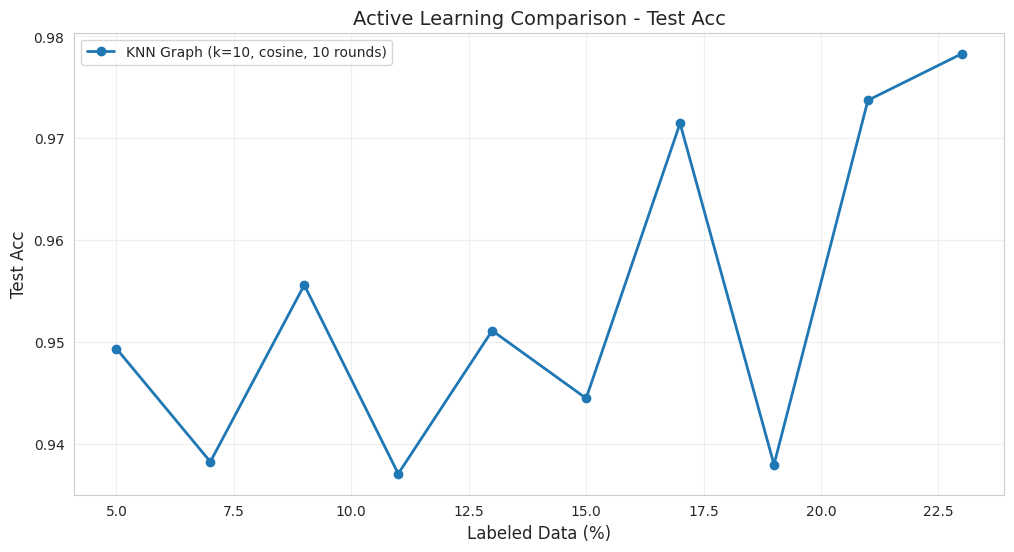

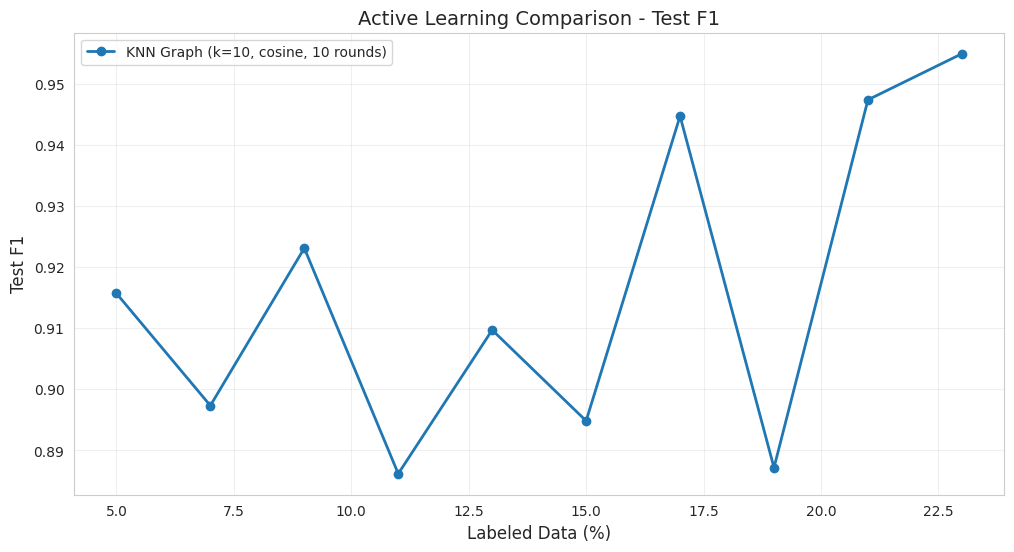


Plotting confusion matrix...


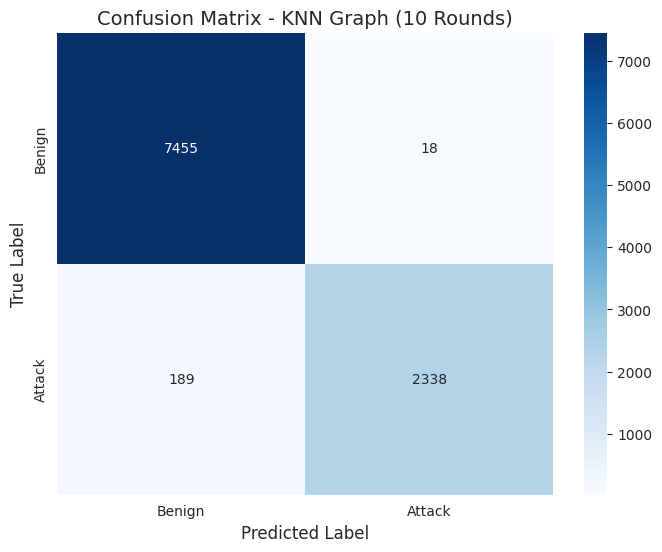


All evaluations completed!


In [15]:
#eval visual
print("Evaluation")
print("="*70)

# Evaluate final model
acc, testf1, testauc = al_engine_knn.evaluate(model_knn, final_graph_knn)

f"Results - KNN Graph:"
f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)"  
f"Test F1-Score: {testf1:.4f} ({testf1*100:.2f}%)"
f"Test AUC: {testauc:.4f} ({testauc*100:.2f}%)"

# Plot learning curves
viz = Visualizer()
print("\nPlotting learning curves...")
viz.plot_al_comparison([history_knn], metric='test_acc')
viz.plot_al_comparison([history_knn], metric='test_f1')

print("\nPlotting confusion matrix...")
model_knn.eval()
with torch.no_grad():
    out = model_knn(final_graph_knn)
    pred = out.argmax(dim=1)

test_mask_tensor = torch.tensor(al_engine_knn.test_mask, dtype=torch.bool).to(device)
y_true = final_graph_knn.y[test_mask_tensor].cpu().numpy()
y_pred = pred[test_mask_tensor].cpu().numpy()

# Sample để plot nhanh
idx = np.random.choice(len(y_true), min(10000, len(y_true)), replace=False)
viz.plot_confusion_matrix(
    y_true[idx], 
    y_pred[idx], 
    title="Confusion Matrix - KNN Graph (10 Rounds)"
)

print("\nAll evaluations completed!")


In [17]:
# save
import torch
import json
from pathlib import Path

# Tạo thư mục output
OUTPUT_DIR = Path('/kaggle/working/saved_models')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("="*70)
print("SAVING ALL OUTPUTS")
print("="*70)

try:
    # 1. Save trained model (state_dict - nhẹ nhất)
    model_path = OUTPUT_DIR / 'gnn_model_state_dict.pth'
    torch.save(model_knn.state_dict(), model_path)
    print(f"✓ Saved model state_dict: {model_path}")
    
    # 2. Save full model (bao gồm architecture)
    full_model_path = OUTPUT_DIR / 'gnn_model_full.pth'
    torch.save(model_knn, full_model_path)
    print(f"✓ Saved full model: {full_model_path}")
    
    # 3. Save complete checkpoint (recommended)
    checkpoint_path = OUTPUT_DIR / 'gnn_checkpoint.pth'
    torch.save({
        'model_state_dict': model_knn.state_dict(),
        'model_config': {
            'input_dim': 77,
            'hidden_dim': 64,
            'num_layers': 3,
            'dropout': 0.3
        },
        'graph_builder': {
            'type': 'FlowBasedKNN',
            'k': 10,
            'metric': 'cosine'
        },
        'training_info': {
            'total_samples': X.shape[0],
            'num_features': X.shape[1],
            'labeled_samples': int(al_engine_knn.train_mask.sum()),
            'labeled_ratio': f"{(al_engine_knn.train_mask.sum() / len(X)) * 100:.1f}%",
            'num_rounds': 10,
            'initial_budget': 0.05,
            'query_budget': 0.02
        },
        'final_metrics': {
            'accuracy': float(acc),      # ← FIXED
            'f1_score': float(testf1),
            'auc': float(testauc)
        }
    }, checkpoint_path)
    print(f"✓ Saved complete checkpoint: {checkpoint_path}")
    
    # 4. Save training history
    history_path = OUTPUT_DIR / 'training_history.json'
    with open(history_path, 'w') as f:
        json.dump(history_knn, f, indent=2)
    print(f"✓ Saved training history: {history_path}")
    
    # 5. Save final evaluation results
    results_path = OUTPUT_DIR / 'final_results.json'
    final_results = {
        'experiment_name': 'GNN Active Learning - KNN Graph',
        'timestamp': '2026-01-02',
        'model_architecture': {
            'type': 'GCNIDS',
            'input_dim': 77,
            'hidden_dim': 64,
            'num_layers': 3,
            'dropout': 0.3
        },
        'graph_builder': {
            'type': 'FlowBasedKNN',
            'k': 10,
            'metric': 'cosine'
        },
        'dataset': {
            'name': 'CICIDS2018',
            'total_samples': X.shape[0],
            'num_features': X.shape[1],
            'benign_samples': int((y == 0).sum()),
            'attack_samples': int((y == 1).sum()),
            'class_distribution': {
                'benign': f"{(y == 0).sum() / len(y) * 100:.1f}%",
                'attack': f"{(y == 1).sum() / len(y) * 100:.1f}%"
            }
        },
        'active_learning': {
            'num_rounds': 10,
            'initial_budget': 0.05,
            'query_budget': 0.02,
            'strategy': 'entropy',
            'labeled_samples': int(al_engine_knn.train_mask.sum()),
            'labeled_ratio': f"{(al_engine_knn.train_mask.sum() / len(X)) * 100:.1f}%"
        },
        'final_performance': {
            'test_accuracy': float(acc),     # ← FIXED
            'test_f1_score': float(testf1),
            'test_auc': float(testauc)
        },
        'training_history': history_knn
    }
    
    with open(results_path, 'w') as f:
        json.dump(final_results, f, indent=2)
    print(f"✓ Saved final results: {results_path}")
    
    # 6. Save inference script template
    inference_script = OUTPUT_DIR / 'load_and_inference.py'
    with open(inference_script, 'w') as f:
        f.write('''"""
Script to load saved model and perform inference
"""
import torch
from torch_geometric.data import Data

# Load checkpoint
checkpoint = torch.load('gnn_checkpoint.pth')

# Recreate model
model = GCNIDS(
    input_dim=checkpoint['model_config']['input_dim'],
    hidden_dim=checkpoint['model_config']['hidden_dim'],
    num_layers=checkpoint['model_config']['num_layers'],
    dropout=checkpoint['model_config']['dropout']
)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Model loaded successfully!")
print(f"Final Accuracy: {checkpoint['final_metrics']['accuracy']:.4f}")
print(f"Final F1-Score: {checkpoint['final_metrics']['f1_score']:.4f}")
print(f"Final AUC: {checkpoint['final_metrics']['auc']:.4f}")

# Inference example (uncomment to use):
# with torch.no_grad():
#     output = model(your_graph_data)
#     predictions = output.argmax(dim=1)
''')
    print(f"✓ Saved inference script: {inference_script}")
    
    print("\n" + "="*70)
    print("✓ ALL FILES SAVED SUCCESSFULLY!")
    print("="*70)
    
    # Print summary
    print("\nSaved files:")
    for file in OUTPUT_DIR.glob('*'):
        size_mb = file.stat().st_size / (1024 * 1024)
        print(f"  - {file.name:30s} ({size_mb:.2f} MB)")
    
    print(f"\nOutput directory: {OUTPUT_DIR}")
    
    # Print key metrics
    print("\n" + "="*70)
    print("FINAL METRICS")
    print("="*70)
    print(f"Test Accuracy:  {acc:.4f} ({acc*100:.2f}%)")        # ← FIXED
    print(f"Test F1-Score:  {testf1:.4f} ({testf1*100:.2f}%)")
    print(f"Test AUC:       {testauc:.4f} ({testauc*100:.2f}%)")
    print(f"Labeled Ratio:  {(al_engine_knn.train_mask.sum() / len(X)) * 100:.1f}%")
    print("="*70)

except Exception as e:
    print(f"\nERROR: {str(e)}")
    import traceback
    traceback.print_exc()


SAVING ALL OUTPUTS
✓ Saved model state_dict: /kaggle/working/saved_models/gnn_model_state_dict.pth
✓ Saved full model: /kaggle/working/saved_models/gnn_model_full.pth
✓ Saved complete checkpoint: /kaggle/working/saved_models/gnn_checkpoint.pth
✓ Saved training history: /kaggle/working/saved_models/training_history.json
✓ Saved final results: /kaggle/working/saved_models/final_results.json
✓ Saved inference script: /kaggle/working/saved_models/load_and_inference.py

✓ ALL FILES SAVED SUCCESSFULLY!

Saved files:
  - gnn_model_full.pth             (0.08 MB)
  - gnn_checkpoint.pth             (0.07 MB)
  - training_history.json          (0.00 MB)
  - load_and_inference.py          (0.00 MB)
  - gnn_model_state_dict.pth       (0.07 MB)
  - final_results.json             (0.00 MB)

Output directory: /kaggle/working/saved_models

FINAL METRICS
Test Accuracy:  0.9783 (97.83%)
Test F1-Score:  0.9549 (95.49%)
Test AUC:       0.9740 (97.40%)
Labeled Ratio:  23.0%


In [23]:
#demo
import torch
import numpy as np
from sklearn.metrics import classification_report
import random

print("="*70)
print("DEMO: TESTING SAVED MODEL")
print("="*70)

# 1. Load model từ checkpoint
print("\n[1/4] Loading model from checkpoint...")
checkpoint = torch.load(OUTPUT_DIR / 'gnn_checkpoint.pth')
model_demo = GCN_IDS(
    input_dim=checkpoint['model_config']['input_dim'],
    hidden_dim=checkpoint['model_config']['hidden_dim'],
    num_layers=checkpoint['model_config']['num_layers'],
    dropout=checkpoint['model_config']['dropout']
).to(device)
model_demo.load_state_dict(checkpoint['model_state_dict'])
model_demo.eval()
print("✓ Model loaded successfully!")

# 2. Prepare test data
print("\n[2/4] Preparing test samples...")
test_mask_indices = np.where(al_engine_knn.test_mask)[0]
num_demo_samples = min(20, len(test_mask_indices))  # 20 samples hoặc ít hơn
demo_indices = random.sample(list(test_mask_indices), num_demo_samples)

# 3. Make predictions
print(f"\n[3/4] Making predictions on {num_demo_samples} random test samples...")
with torch.no_grad():
    output = model_demo(final_graph_knn)
    probs = torch.softmax(output, dim=1)
    predictions = output.argmax(dim=1)

# Extract demo results
demo_true = y[demo_indices]
demo_pred = predictions[demo_indices].cpu().numpy()
demo_probs = probs[demo_indices].cpu().numpy()

# 4. Display results
print("\n[4/4] Demo Results:")
print("="*70)
print(f"{'#':<4} {'True':<10} {'Predicted':<12} {'Confidence':<12} {'Status':<10}")
print("-"*70)

correct = 0
for i, idx in enumerate(demo_indices):
    true_label = "Benign" if demo_true[i] == 0 else "Attack"
    pred_label = "Benign" if demo_pred[i] == 0 else "Attack"
    confidence = demo_probs[i][demo_pred[i]] * 100
    status = "✓ Correct" if demo_true[i] == demo_pred[i] else "✗ Wrong"
    
    if demo_true[i] == demo_pred[i]:
        correct += 1
    
    print(f"{i+1:<4} {true_label:<10} {pred_label:<12} {confidence:>6.2f}%      {status:<10}")

print("="*70)
print(f"\nDemo Accuracy: {correct}/{num_demo_samples} = {correct/num_demo_samples*100:.2f}%")


print("\n" + "="*70)
print("FULL TEST SET EVALUATION")
print("="*70)

test_true = y[al_engine_knn.test_mask]
test_pred = predictions[al_engine_knn.test_mask].cpu().numpy()

report = classification_report(
    test_true, 
    test_pred,
    target_names=['Benign', 'Attack'],
    digits=4
)
print(report)

# Confusion matrix breakdown
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_true, test_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Benign → Benign):   {tn:>8,} ✓")
print(f"  False Positives (Benign → Attack):  {fp:>8,} ✗")
print(f"  False Negatives (Attack → Benign):  {fn:>8,} ✗")
print(f"  True Positives (Attack → Attack):   {tp:>8,} ✓")
print(f"\n  Total Correct:   {tn + tp:>8,} ({(tn + tp)/len(test_true)*100:.2f}%)")
print(f"  Total Incorrect: {fp + fn:>8,} ({(fp + fn)/len(test_true)*100:.2f}%)")

# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
fpr = fp / (fp + tn) * 100  # False Positive Rate
fnr = fn / (fn + tp) * 100  # False Negative Rate

print(f"False Positive Rate: {fpr:.2f}%")
print(f"  → {fpr:.2f}% benign flows bị nhầm là attack")
print(f"\nFalse Negative Rate: {fnr:.2f}%")
print(f"  → {fnr:.2f}% attack flows bị bỏ sót (nguy hiểm!)")

if fnr < 5:
    print(f"\nModel rất tốt! FNR < 5% (chỉ bỏ sót {fnr:.2f}% attacks)")
elif fnr < 10:
    print(f"\nModel khá tốt! FNR < 10% (bỏ sót {fnr:.2f}% attacks)")
else:
    print(f"\nModel cần cải thiện! FNR = {fnr:.2f}% (bỏ sót nhiều attacks)")


DEMO: TESTING SAVED MODEL

[1/4] Loading model from checkpoint...
✓ Model loaded successfully!

[2/4] Preparing test samples...

[3/4] Making predictions on 20 random test samples...

[4/4] Demo Results:
#    True       Predicted    Confidence   Status    
----------------------------------------------------------------------
1    Benign     Benign        99.45%      ✓ Correct 
2    Benign     Benign        89.51%      ✓ Correct 
3    Benign     Benign        95.99%      ✓ Correct 
4    Benign     Benign        92.38%      ✓ Correct 
5    Benign     Benign        99.23%      ✓ Correct 
6    Benign     Benign        98.93%      ✓ Correct 
7    Benign     Benign        98.49%      ✓ Correct 
8    Benign     Benign        99.33%      ✓ Correct 
9    Benign     Benign        99.25%      ✓ Correct 
10   Attack     Attack        99.58%      ✓ Correct 
11   Benign     Benign        99.19%      ✓ Correct 
12   Benign     Benign        97.84%      ✓ Correct 
13   Benign     Benign        99.21%